In [ ]:
!git clone https://github.com/PraveerT/protein.git

In [2]:
!pip install proteinshake

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 270.1/270.1 kB 8.5 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 69.9/69.9 kB 5.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 68.3/68.3 kB 6.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.3/3.3 MB 43.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 15.8/15.8 MB 47.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 34.9/34.9 MB 20.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 172.3/172.3 kB 16.2 MB/s eta 0:00:00
  Created wheel for freesasa: filename=freesasa-2.2.1-cp311-cp311-linux_x86_64.whl size=888786 sha256=790b4ec50eabd982f60d4898fab8e992476fac01ac5d3532817636774ada86ac
  Stored in directory: /root/.cache/pip/wheels/12/7e/68/f3f59a0c5946b122ecbf6098c87de4c8a1f73ec145c077815b
  Created wheel for docopt: filename=docopt-0.6.2-py2.py3-none-any.whl size=13706 sha256=15

In [3]:
from proteinshake.tasks import EnzymeClassTask
import numpy as np
import torch

# Use proteins with Enzyme Class annotations
task = EnzymeClassTask().to_point().torch()

100%|██████████| 9.00k/9.00k [00:51<00:00, 1.84MiB/s]


Unzipping...


Converting: 100%|██████████| 15603/15603 [00:16<00:00, 936.68it/s]


In [4]:
import torch
from torch.utils.data import Dataset
import pandas as pd
import numpy as np

class EnzymeDataset(Dataset):
    def __init__(self, torchdrug_dataset, max_points=512):
        self.dataset = torchdrug_dataset
        self.max_points = max_points
        self.amino_acids = ['A', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'K', 'L',
                              'M', 'N', 'P', 'Q', 'R', 'S', 'T', 'V', 'W', 'Y']

    def __len__(self):
        return len(self.dataset)

    def __getitem__(self, idx):
        sample = self.dataset[idx]

        point_cloud_data = sample[0]
        metadata = sample[1]

        sasa_features = torch.tensor(metadata['residue']['SASA'], dtype=torch.float).unsqueeze(1)
        rsa_features = torch.tensor(metadata['residue']['RSA'], dtype=torch.float).unsqueeze(1)

        residue_types = metadata['residue']['residue_type']

        # create dataframe
        one_hot_df = pd.get_dummies(pd.Series(residue_types))
        one_hot_df = one_hot_df.reindex(columns=self.amino_acids, fill_value=0)
        numpy_array = one_hot_df.values.astype(np.float32)
        one_hot_features = torch.from_numpy(numpy_array)

        all_features = torch.cat([
            point_cloud_data,
            sasa_features,
            rsa_features,
            one_hot_features
        ], dim=1)

        num_points = all_features.shape[0]
        num_channels = all_features.shape[1]

        padded_features = torch.zeros(self.max_points, num_channels)

        if num_points > self.max_points:
            padded_features = all_features[:self.max_points, :]
        else:
            padded_features[:num_points, :] = all_features

        ec_number_str = metadata['protein']['EC']
        try:
            label = int(ec_number_str.split('.')[0]) - 1
        except (ValueError, IndexError):
            # label -1 if EC is missing
            label = -1

        label_tensor = torch.tensor(label, dtype=torch.long)

        return padded_features, label_tensor

In [5]:
from torch.utils.data import DataLoader

MAX_POINTS = 1024
BATCH_SIZE = 32

# Initialize dataset
train_dataset = EnzymeDataset(task.train, max_points=MAX_POINTS)
val_dataset = EnzymeDataset(task.val, max_points=MAX_POINTS)
test_dataset = EnzymeDataset(task.test, max_points=MAX_POINTS)

# Initialize DataLoader
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=4)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=4)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=4)

features_batch, labels_batch = next(iter(train_loader))

print(f"Shape of batch features: {features_batch.shape}")
print(f"Shape of batch labels: {labels_batch.shape}")

/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Shape of batch features: torch.Size([32, 1024, 26])
Shape of batch labels: torch.Size([32])


In [6]:
from proteinshake.tasks import EnzymeClassTask
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
import random


# Quaternion Helper Functions

def normalize_quat(q):
    """Normalize to unit quaternion."""
    return F.normalize(q, p=2, dim=-1)

def random_unit_quaternion(device='cpu'):
    """Generate a random unit quaternion representing a 3D rotation."""
    # Uniform sampling on SO(3) using axis-angle representation
    axis = torch.randn(3, device=device)
    axis = F.normalize(axis, p=2, dim=0)
    angle = torch.rand(1, device=device) * 2.0 * np.pi
    w = torch.cos(angle / 2.0)
    xyz = axis * torch.sin(angle / 2.0)
    q = torch.cat([w, xyz], dim=0) # Shape [4]
    return q

def quaternion_multiply(q1, q2):
    """Multiply two quaternions q1 * q2."""
    # Handles q1=[4], q2=[N,4] or q1=[4], q2=[4]
    w1, x1, y1, z1 = q1[0], q1[1], q1[2], q1[3]
    if q2.dim() == 1: # q2 is [4]
       w2, x2, y2, z2 = q2[0], q2[1], q2[2], q2[3]
       w = w1 * w2 - x1 * x2 - y1 * y2 - z1 * z2
       x = w1 * x2 + x1 * w2 + y1 * z2 - z1 * y2
       y = w1 * y2 - x1 * z2 + y1 * w2 + z1 * x2
       z = w1 * z2 + x1 * y2 - y1 * x2 + z1 * w2
       return torch.stack([w, x, y, z])
    elif q2.dim() == 2: # q2 is [N, 4]
        w2, x2, y2, z2 = q2[:, 0], q2[:, 1], q2[:, 2], q2[:, 3]
        w = w1 * w2 - x1 * x2 - y1 * y2 - z1 * z2
        x = w1 * x2 + x1 * w2 + y1 * z2 - z1 * y2
        y = w1 * y2 - x1 * z2 + y1 * w2 + z1 * x2
        z = w1 * z2 + x1 * y2 - y1 * x2 + z1 * w2
        return torch.stack([w, x, y, z], dim=1) # Result is [N, 4]
    else:
        raise ValueError("Unsupported shapes for quaternion_multiply")

def quaternion_conjugate(q):
    """Compute the conjugate of a quaternion or batch of quaternions."""
    q_conj = q.clone()
    q_conj[..., 1:] *= -1
    return q_conj

def rotate_points_by_quaternion(points, q):
    """Rotate points (N, 3) by a unit quaternion q (4)."""
    device = points.device
    q = q.to(device)
    points_quat = F.pad(points, (1, 0), mode='constant', value=0)
    q_conj = quaternion_conjugate(q)
    # Perform q * points_quat * q_conj
    rotated_quat_intermediate = quaternion_multiply(q, points_quat)
    # Manually implement intermediate * q_conj for clarity with shapes
    w_mid, x_mid, y_mid, z_mid = rotated_quat_intermediate[:, 0], rotated_quat_intermediate[:, 1], rotated_quat_intermediate[:, 2], rotated_quat_intermediate[:, 3]
    w_conj, x_conj, y_conj, z_conj = q_conj[0], q_conj[1], q_conj[2], q_conj[3]
    w_final = w_mid * w_conj - x_mid * x_conj - y_mid * y_conj - z_mid * z_conj
    x_final = w_mid * x_conj + x_mid * w_conj + y_mid * z_conj - z_mid * y_conj
    y_final = w_mid * y_conj - x_mid * z_conj + y_mid * w_conj + z_mid * x_conj
    z_final = w_mid * z_conj + x_mid * y_conj - y_mid * x_conj + z_mid * w_conj
    rotated_quat_final = torch.stack([w_final, x_final, y_final, z_final], dim=1)
    rotated_points = rotated_quat_final[:, 1:]
    return rotated_points

# Augmentation Functions

def random_quaternion_rotate_point_cloud(points):
     """ Randomly rotate the point cloud using a unit quaternion. """
     q = random_unit_quaternion(device=points.device)
     return rotate_points_by_quaternion(points, q)

def random_scale_point_cloud(points, scale_low=0.8, scale_high=1.2):
    """ Randomly scale the point cloud uniformly. """
    scale = random.uniform(scale_low, scale_high)
    return points * scale

def random_jitter_point_cloud(points, sigma=0.01, clip=0.05):
    """ Randomly jitter point positions. """
    jitter = torch.randn(*points.shape, device=points.device) * sigma
    jitter = torch.clamp(jitter, -clip, clip)
    return points + jitter

# PointCloudDataset
class PointCloudDataset(Dataset):
    # Initialization
    def __init__(self, data_source, augment=False, jitter_sigma=0.01, jitter_clip=0.05, scale_low=0.8, scale_high=1.2):
        self.data = []
        self.labels = []
        self.augment = augment
        self.jitter_sigma = jitter_sigma
        self.jitter_clip = jitter_clip
        self.scale_low = scale_low
        self.scale_high = scale_high

        print(f"Initializing Dataset. Augmentation: {self.augment}")

        # Use proteins with Enzyme Class annotations
        try:
            task_data = list(data_source) # Convert generator to list if needed
        except TypeError: # Handle if it's already list-like
             task_data = data_source

        if not task_data:
             print("Warning: Data source is empty.")
             return # Handle empty data source

        for item in task_data:
            points, meta = item
            xyz = points[:, :3]
            ec_str = meta['protein']['EC']

            label = int(ec_str.split('.')[0])-1

            self.data.append(torch.tensor(xyz, dtype=torch.float32))
            self.labels.append(label)

        if self.labels:
             self.labels = torch.tensor(self.labels, dtype=torch.long)
             print(f"Dataset initialized with {len(self.labels)} samples.")
        else:
             self.labels = torch.tensor([], dtype=torch.long) # Empty tensor
             print("Dataset initialized with 0 samples.")


    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        # (Same as previous answer - uses the standalone helpers)
        points = self.data[idx].clone()
        label = self.labels[idx]

        if self.augment:
            points = random_scale_point_cloud(points, self.scale_low, self.scale_high)
            points = random_quaternion_rotate_point_cloud(points) # Uses standalone helpers
            points = random_jitter_point_cloud(points, self.jitter_sigma, self.jitter_clip)

        return points, label

# Use proteins with Enzyme Class annotations
task = EnzymeClassTask().to_point().torch()

# Collate Function
def variable_size_collate_fn(batch):
    points_list = [item[0] for item in batch]
    labels = torch.tensor([item[1] for item in batch], dtype=torch.long)
    return points_list, labels

# Dataset and DataLoader Setup
train_dataset = PointCloudDataset(task.train, augment=True)

# Check if dataset is empty before proceeding
if len(train_dataset) == 0:
    raise ValueError("Training dataset is empty. Check data loading and filtering.")

num_class = len(torch.unique(train_dataset.labels))
# test_dataset = PointCloudDataset(task.test, augment=False) # Created inside test_step

train_dataloader = DataLoader(train_dataset, batch_size=32, shuffle=True, collate_fn=variable_size_collate_fn)


# Model Definition
class PointCloudClassifier(nn.Module):
    def __init__(self, num_classes=6):
        super(PointCloudClassifier, self).__init__()
        self.conv1 = nn.Conv1d(3, 64, 1)
        self.conv2 = nn.Conv1d(64, 128, 1)
        self.conv3 = nn.Conv1d(128, 1024, 1)
        self.fc1 = nn.Linear(1024, 512)
        self.fc2 = nn.Linear(512, 256)
        self.fc3 = nn.Linear(256, num_classes)
        self.dropout = nn.Dropout(p=0.3)
        self.bn1 = nn.BatchNorm1d(64)
        self.bn2 = nn.BatchNorm1d(128)
        self.bn3 = nn.BatchNorm1d(1024)
        self.bn4 = nn.BatchNorm1d(512)
        self.bn5 = nn.BatchNorm1d(256)

    def forward(self, x):
         # x: list of point clouds with shape [N_i, 3] or tensor [B, 3, N]
        if isinstance(x, torch.Tensor) and x.dim() == 3 and x.shape[1] == 3:
             padded = x
        elif isinstance(x, list):
            batch_size = len(x)
            if batch_size == 0:
                 return torch.zeros((0, self.fc3.out_features), device=self.fc3.weight.device)
            device = x[0].device if batch_size > 0 else self.fc3.weight.device # Handle empty list case
            max_points = max(pc.shape[0] for pc in x) if batch_size > 0 else 0
            padded = torch.zeros((batch_size, 3, max_points), device=device)
            for i, pc in enumerate(x):
                if pc.shape[0] > 0:
                    padded[i, :, :pc.shape[0]] = pc.T
        else:
             raise TypeError(f"Unsupported input type for PointCloudClassifier: {type(x)}")

        if padded.shape[0] == 0:
            return torch.zeros((0, self.fc3.out_features), device=padded.device)

        x = F.relu(self.bn1(self.conv1(padded)))
        x = F.relu(self.bn2(self.conv2(x)))
        x = F.relu(self.bn3(self.conv3(x)))

        if x.shape[2] == 0: # Handle empty point clouds after padding
             x = torch.zeros(x.shape[0], x.shape[1], device=x.device) # [B, 1024]
        else:
             x = torch.max(x, 2)[0]                      # [B, 1024]

        x = F.relu(self.bn4(self.fc1(x)))
        x = F.relu(self.bn5(self.dropout(self.fc2(x))))
        x = self.fc3(x)
        return x

    def test_step(self, test_data_source, batch_size=32):
        self.eval()
        # Create dataset inside test_step to ensure no augmentation
        dataset = PointCloudDataset(test_data_source, augment=False)
        if len(dataset) == 0:
            print("Warning: Test dataset is empty.")
            return torch.empty(0, dtype=torch.long), torch.empty(0, dtype=torch.long)

        dataloader = DataLoader(dataset, batch_size=batch_size, collate_fn=variable_size_collate_fn)
        all_preds = []
        all_labels = []
        device = next(self.parameters()).device

        with torch.no_grad():
            for points_list, labels in dataloader:
                points_list = [pc.to(device) for pc in points_list]
                labels = labels.to(device)
                if not points_list: continue # Skip empty batch

                outputs = self(points_list)
                if outputs.shape[0] > 0: # Ensure output is not empty
                    preds = torch.argmax(outputs, dim=1)
                    all_preds.append(preds.cpu())
                    all_labels.append(labels.cpu())

        if not all_preds:
            print("Warning: No predictions generated during testing.")
            return torch.empty(0, dtype=torch.long), torch.empty(0, dtype=torch.long)

        all_preds = torch.cat(all_preds)
        all_labels = torch.cat(all_labels)
        accuracy = (all_preds == all_labels).float().mean().item()
        print(f"Test Accuracy: {accuracy:.4f}")
        return all_preds, all_labels

# Training Loop
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")
print(f"Number of classes: {num_class}")

model = PointCloudClassifier(num_classes=num_class).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
criterion = nn.CrossEntropyLoss()

num_epochs = 10

print("Starting Training...")
for epoch in range(num_epochs):
    model.train()
    total_loss = 0
    processed_batches = 0
    for points_list, labels in train_dataloader:
        points_list = [pc.to(device) for pc in points_list]
        labels = labels.to(device)
        if not points_list: continue

        optimizer.zero_grad()
        outputs = model(points_list)
        if outputs.shape[0] == 0: continue
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
        processed_batches += 1

    if processed_batches > 0:
        avg_loss = total_loss / processed_batches
        print(f"Epoch {epoch}, Loss: {avg_loss:.4f}")
    else:
        print(f"Epoch {epoch}, No batches processed (potential issue with dataloader?).")


print("Training Finished.")

# Testing
print("Starting Testing...")
predictions, test_labels = model.test_step(task.test)
print("Testing Finished.")

from sklearn.metrics import classification_report
if len(predictions) > 0:
      print(classification_report(test_labels.numpy(), predictions.numpy()))

Initializing Dataset. Augmentation: True


/tmp/ipython-input-6-3301876075.py:122: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.data.append(torch.tensor(xyz, dtype=torch.float32))


Dataset initialized with 14042 samples.
Using device: cuda
Number of classes: 7
Starting Training...
Epoch 0, Loss: 1.5223
Epoch 1, Loss: 1.4981
Epoch 2, Loss: 1.4914
Epoch 3, Loss: 1.4899
Epoch 4, Loss: 1.4874
Epoch 5, Loss: 1.4876
Epoch 6, Loss: 1.4848
Epoch 7, Loss: 1.4860
Epoch 8, Loss: 1.4831
Epoch 9, Loss: 1.4818
Training Finished.
Starting Testing...
Initializing Dataset. Augmentation: False
Dataset initialized with 781 samples.


/tmp/ipython-input-6-3301876075.py:122: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.data.append(torch.tensor(xyz, dtype=torch.float32))


Test Accuracy: 0.3764
Testing Finished.
              precision    recall  f1-score   support

           0       0.00      0.00      0.00       115
           1       0.30      0.02      0.04       248
           2       0.38      0.97      0.54       296
           3       0.00      0.00      0.00        67
           4       0.00      0.00      0.00        31
           5       0.00      0.00      0.00        17
           6       0.00      0.00      0.00         7

    accuracy                           0.38       781
   macro avg       0.10      0.14      0.08       781
weighted avg       0.24      0.38      0.22       781



/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Extracting and processing labels from train dataset...


Processing train set:   0%|          | 0/14042 [00:00<?, ?it/s]

Processing complete! All valid labels: 14042


/tmp/ipython-input-7-3333846999.py:43: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  barplot = sns.barplot(x=label_names, y=counts, palette='viridis')


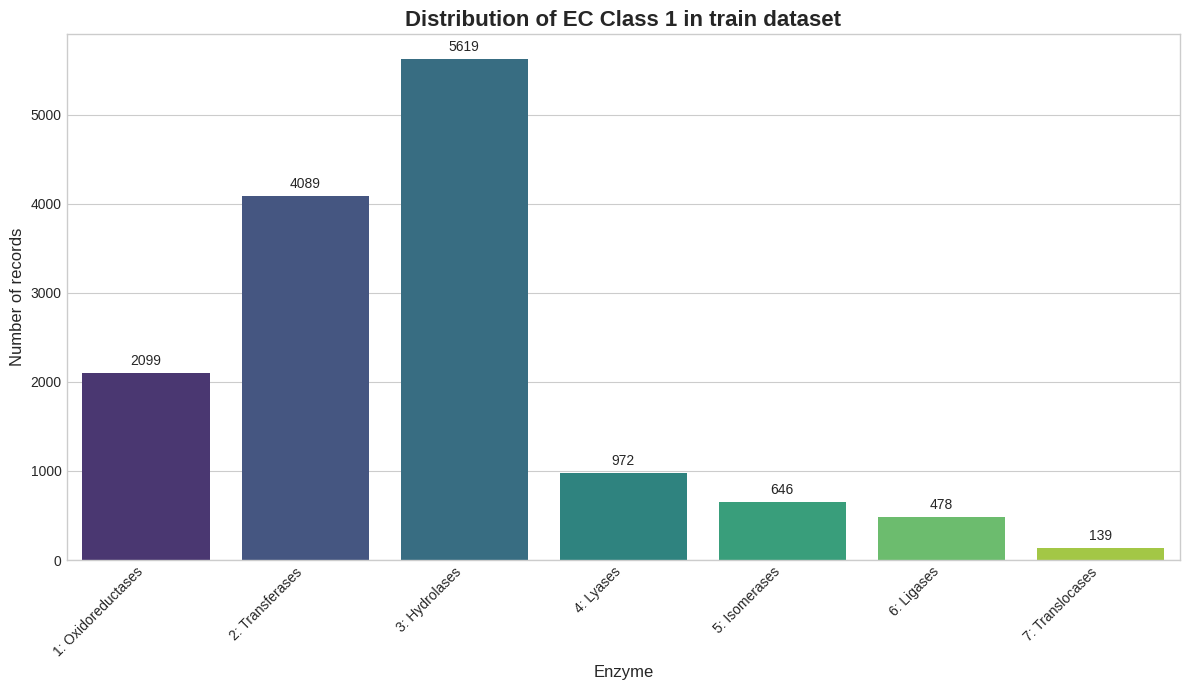

In [7]:
import torch
from collections import Counter
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm.notebook import tqdm

print("Extracting and processing labels from train dataset...")

# Create list for storing EC class 1
first_ec_classes = []

for sample in tqdm(task.train, desc="Processing train set"):
    metadata = sample[1]
    ec_number_str = metadata['protein']['EC']

    try:
        first_class = int(ec_number_str.split('.')[0])
        first_ec_classes.append(first_class)
    except (ValueError, IndexError):
        continue

print(f"Processing complete! All valid labels: {len(first_ec_classes)}")

label_counts = Counter(first_ec_classes)
sorted_counts = {i: label_counts.get(i, 0) for i in range(1, 8)}

labels = list(sorted_counts.keys())
counts = list(sorted_counts.values())

class_names = {
    1: '1: Oxidoreductases',
    2: '2: Transferases',
    3: '3: Hydrolases',
    4: '4: Lyases',
    5: '5: Isomerases',
    6: '6: Ligases',
    7: '7: Translocases'
}
label_names = [class_names.get(l, f'{l}') for l in labels]
plt.style.use('seaborn-v0_8-whitegrid')
plt.figure(figsize=(12, 7))

barplot = sns.barplot(x=label_names, y=counts, palette='viridis')

for index, value in enumerate(counts):
    plt.text(index, value + (max(counts) * 0.01), f'{value}', ha='center', va='bottom', fontsize=10)

plt.title('Distribution of EC Class 1 in train dataset', fontsize=16, fontweight='bold')
plt.xlabel('Enzyme', fontsize=12)
plt.ylabel('Number of records', fontsize=12)
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

In [8]:
sample_features, sample_label = test_dataset[0]

print("Shape of sample feature:", sample_features.shape)
print("Label of sample:", sample_label)

print("Display input features:")
print(sample_features[:1])

Shape of sample feature: torch.Size([1024, 26])
Label of sample: tensor(1)
Display input features:
tensor([[  5.8520, -19.9890,  -9.7530,  12.0000,  75.4516,   0.3907,   0.0000,
           0.0000,   0.0000,   0.0000,   0.0000,   0.0000,   0.0000,   0.0000,
           0.0000,   0.0000,   1.0000,   0.0000,   0.0000,   0.0000,   0.0000,
           0.0000,   0.0000,   0.0000,   0.0000,   0.0000]])


In [9]:
import torch
import torch.nn as nn
from protein.pointlstm import PointLSTM

class EnzymeClassifier(nn.Module):
    def __init__(self, num_points, in_channels, hidden_dim, num_classes=7, num_lstm_layers=2):
        super(EnzymeClassifier, self).__init__()

        self.num_points = num_points
        self.in_channels = in_channels
        self.hidden_dim = hidden_dim

        self.point_lstm = PointLSTM(
            pts_num=self.num_points,
            in_channels=self.in_channels,
            hidden_dim=self.hidden_dim,
            offset_dim=4,
            num_layers=num_lstm_layers,
            batch_first=True
        )

        self.classifier = nn.Sequential(
            nn.Linear(self.hidden_dim, self.hidden_dim // 2),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(self.hidden_dim // 2, num_classes)
        )

    def forward(self, x):
        x_transposed = x.transpose(1, 2)
        input_for_lstm = x_transposed.unsqueeze(1)

        _, last_state_list, _ = self.point_lstm(input_for_lstm)
        last_hidden_state = last_state_list[-1][0]
        pooled_state = last_hidden_state.squeeze(-1)
        pooled_state = torch.max(pooled_state, dim=2)[0]
        logits = self.classifier(pooled_state)

        return logits

In [10]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# Hyperparameters
NUM_POINTS = 1024
IN_CHANNELS = 26
HIDDEN_DIM = 128
NUM_CLASSES = 7
NUM_LSTM_LAYERS = 2
LEARNING_RATE = 1e-4
EPOCHS = 10

model = EnzymeClassifier(
    num_points=NUM_POINTS,
    in_channels=IN_CHANNELS,
    hidden_dim=HIDDEN_DIM,
    num_classes=NUM_CLASSES,
    num_lstm_layers=NUM_LSTM_LAYERS
).to(device)

# Number of records of each class from the bar graph
counts = [2099, 4089, 5619, 972, 646, 478, 139]

# Calculate weight per class
class_weights = 1.0 / torch.tensor(counts, dtype=torch.float)

# Normalize class weights
class_weights = class_weights / class_weights.sum() * len(counts)
class_weights = class_weights.to(device)
print(f"Class weights: {class_weights}")

loss_function = nn.CrossEntropyLoss(weight=class_weights)
optimizer = torch.optim.Adam(model.parameters(), lr=LEARNING_RATE)

# Training loop
for epoch in range(EPOCHS):
    model.train()
    total_train_loss = 0
    train_correct = 0
    total_train_samples = 0

    for features_batch, labels_batch in train_loader:
        valid_indices = labels_batch != -1
        if not valid_indices.any():
            continue

        features_batch = features_batch[valid_indices].to(device)
        labels_batch = labels_batch[valid_indices].to(device)
        optimizer.zero_grad()
        outputs = model(features_batch)
        loss = loss_function(outputs, labels_batch)
        loss.backward()
        optimizer.step()

        total_train_loss += loss.item() * features_batch.size(0)
        _, predicted = torch.max(outputs.data, 1)
        train_correct += (predicted == labels_batch).sum().item()
        total_train_samples += features_batch.size(0)

    avg_train_loss = total_train_loss / total_train_samples
    train_accuracy = 100 * train_correct / total_train_samples

    # Validation phase
    model.eval()
    total_val_loss = 0
    val_correct = 0
    total_val_samples = 0

    with torch.no_grad():
        for features_batch, labels_batch in val_loader:
            valid_indices = labels_batch != -1
            if not valid_indices.any():
                continue

            features_batch = features_batch[valid_indices].to(device)
            labels_batch = labels_batch[valid_indices].to(device)

            outputs = model(features_batch)
            loss = loss_function(outputs, labels_batch)

            total_val_loss += loss.item() * features_batch.size(0)
            _, predicted = torch.max(outputs.data, 1)
            val_correct += (predicted == labels_batch).sum().item()
            total_val_samples += features_batch.size(0)

    avg_val_loss = total_val_loss / total_val_samples
    val_accuracy = 100 * val_correct / total_val_samples

    print(f'Epoch [{epoch+1}/{EPOCHS}], '
          f'Train Loss: {avg_train_loss:.4f}, Train Acc: {train_accuracy:.2f}%, '
          f'Val Loss: {avg_val_loss:.4f}, Val Acc: {val_accuracy:.2f}%')


Using device: cuda
Class weights: tensor([0.2613, 0.1341, 0.0976, 0.5643, 0.8491, 1.1475, 3.9461],
       device='cuda:0')


/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Epoch [1/10], Train Loss: 1.9415, Train Acc: 27.52%, Val Loss: 1.9369, Val Acc: 34.74%
Epoch [2/10], Train Loss: 1.9309, Train Acc: 25.17%, Val Loss: 1.9319, Val Acc: 31.92%
Epoch [3/10], Train Loss: 1.9248, Train Acc: 23.81%, Val Loss: 1.9298, Val Acc: 27.69%
Epoch [4/10], Train Loss: 1.9197, Train Acc: 25.75%, Val Loss: 1.9244, Val Acc: 29.10%
Epoch [5/10], Train Loss: 1.9118, Train Acc: 24.61%, Val Loss: 1.9245, Val Acc: 28.72%
Epoch [6/10], Train Loss: 1.9081, Train Acc: 25.25%, Val Loss: 1.9198, Val Acc: 26.03%
Epoch [7/10], Train Loss: 1.9035, Train Acc: 24.37%, Val Loss: 1.9161, Val Acc: 25.51%
Epoch [8/10], Train Loss: 1.8934, Train Acc: 24.34%, Val Loss: 1.9156, Val Acc: 27.44%
Epoch [9/10], Train Loss: 1.8880, Train Acc: 24.50%, Val Loss: 1.9124, Val Acc: 29.36%
Epoch [10/10], Train Loss: 1.8833, Train Acc: 23.94%, Val Loss: 1.9128, Val Acc: 30.90%


In [11]:
from sklearn.metrics import classification_report

model.eval()

all_preds = []
all_labels = []

with torch.no_grad():
    for features_batch, labels_batch in val_loader:
        valid_indices = labels_batch != -1
        if not valid_indices.any():
            continue

        features_batch = features_batch[valid_indices].to(device)
        labels_batch = labels_batch[valid_indices].to(device)

        outputs = model(features_batch)
        _, predicted = torch.max(outputs.data, 1)

        all_preds.extend(predicted.cpu().numpy())
        all_labels.extend(labels_batch.cpu().numpy())

target_names = [f"EC class {i+1}" for i in range(NUM_CLASSES)]
print(classification_report(all_labels, all_preds, target_names=target_names))


              precision    recall  f1-score   support

  EC class 1       0.20      0.37      0.26       118
  EC class 2       0.36      0.25      0.29       230
  EC class 3       0.52      0.39      0.45       303
  EC class 4       0.13      0.31      0.19        55
  EC class 5       0.17      0.03      0.05        32
  EC class 6       0.13      0.09      0.11        34
  EC class 7       0.00      0.00      0.00         8

    accuracy                           0.31       780
   macro avg       0.22      0.21      0.19       780
weighted avg       0.36      0.31      0.32       780

